In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from keras.models import load_model
from google.colab import drive
# import face_recognition
# import facenet
# drive.mount('/content/gdrive')

model = load_model('/content/gdrive/MyDrive/facenet/facenet_keras.h5')
model.summary()
# model_wieghts = load_model('/content/gdrive/MyDrive/facenet/facenet_keras_weights.h5')

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

     |████████████████████████████████| 2.3 MB 8.7 MB/s 
(160, 160, 3)
(160, 160, 3)


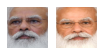

In [3]:
!pip install mtcnn
	
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from numpy import load
from numpy import expand_dims
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

def extract_face(filename, required_size=(160, 160)):
	# load image from file
  image = Image.open(filename)
	# convert to RGB, if needed
  image = image.convert('RGB')
	# convert to array
  pixels = asarray(image)
	# create the detector, using default weights
  detector = MTCNN()
	# detect faces in the image
  results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
  x1, y1, width, height = results[0]['box']
	# bug fix
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
	# extract the face
  face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = asarray(image)
  # print(face_array)
  return face_array

face1 = extract_face('/content/gdrive/MyDrive/modi/modi1.jpeg')
face2 = extract_face('/content/gdrive/MyDrive/modi/modi2.jpg')
print( face1.shape)
print( face2.shape)
pyplot.subplot(2, 7, 1)
pyplot.axis('off')
pyplot.imshow(face1)
pyplot.subplot(2, 7, 2)
pyplot.axis('off')
pyplot.imshow(face2)
pyplot.show()

In [4]:
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path,required_size=(160,160))
		# store
		faces.append(face)
	return faces

In [5]:
from os import listdir
from os.path import isdir
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
 
# load train dataset
trainX, trainy = load_dataset('/content/gdrive/MyDrive/face_recognition_data/train/')
print(trainX.shape, trainy.shape)

# load test dataset
testX, testy = load_dataset('/content/gdrive/MyDrive/face_recognition_data/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)


>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 19 examples for class: madonna
>loaded 21 examples for class: jerry_seinfeld
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: madonna
(25, 160, 160, 3) (25,)


In [7]:
from numpy import load
from numpy import expand_dims

def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]



data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('/content/gdrive/MyDrive/facenet/facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)
print(newTrainX)


Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
Loaded Model
Cause: could not parse the source code of <function <lambda> at 0x7fa4179f8f80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fa4179f8f80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fa3687d10e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fa3687d10e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fa3687d1e60>: no matching AST found
To silence this warning, decorate the f

Predicted: ben_afflek (88.166)
Expected: ben_afflek


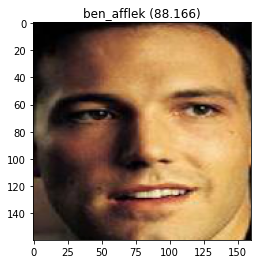

In [8]:
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()